In [1]:
from glob import glob
import pandas as pd
from scipy.stats import mannwhitneyu, fisher_exact
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_style('whitegrid')

def p_adjust(pvalues, method='fdr_bh'):
    res = multipletests(pvalues, method=method)
    return np.array(res[1], dtype=float)

def measure_enrichment(sig_kos, modules, all_module_kos):
    enrichment_rows = list()
    for module, module_kos in modules.items():
        in_in = len(sig_kos & module_kos)  # in module and in gene set
        in_out = len(sig_kos - module_kos)  # in gene set and out of module
        out_in = len(module_kos - sig_kos)  # in module and out of gene set
        out_out = len(all_module_kos - module_kos - sig_kos)

        odds_ratio, p_value = fisher_exact([[in_in, in_out],
                                            [out_in, out_out]], alternative='greater')
        enrichment_rows.append([module, len(module_kos), in_in, in_out, out_in, out_out, odds_ratio, p_value])
    enrichment = pd.DataFrame(enrichment_rows, columns=['module', 'module_size', 'in_in', 'in_out', 'out_in', 'out_out', 'odds_ratio', 'p_value']).set_index('module').sort_values('p_value')
    enrichment['p_adj'] = p_adjust(enrichment['p_value'])
    return enrichment

# Correlate titers with KOs

## Read in data

In [2]:
meta = pd.read_csv('../../data/metadata/stool/stool_metadata.csv', index_col='SampleID')
meta = pd.concat([meta,
                  pd.read_csv('../../data/metadata/stool/stool_abx_usage.csv', index_col='SampleID'),
                  pd.read_csv('../../data/metadata/stool/stool_titers_yr1.csv', index_col='SampleID')],
                 axis=1)
meta = meta.query("`gt_2.5` == True")
meta['VR_group'] = meta['VR_group'].fillna('Not Measured')
meta = meta.sort_values(['BabyN', 'age_at_collection'])
meta = meta.loc[~pd.isna(meta['median_mmNorm'])]
meta.head()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,BabyN_checked,...,median_mmNorm_PCV,median_mmNorm_DTAPHib,protectNorm_Dip,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2
SampleID,,,,,,,,,,,,,,,,,,,,,
106_V2,Primary in Tube,69,NaN,NaN,"Box 8, F3",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR
106_V6,Primary in Tube,121,NaN,NaN,"Box 10, C1",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR
106_V7,Primary in Tube,158,NaN,NaN,"Box 11, C3",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR
106_S_1,Primary in Tube,162,NaN,NaN,"Box 11, D1",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR
106_A1,Primary in Tube,188,NaN,NaN,"Box 12, B3",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR


In [3]:
ko_abunds = pd.read_csv('../../data/stool/ko_abundance_table.rel.tsv', sep='\t', index_col=0)
ko_abunds.index = [i.replace("'", "_").replace('#', '_') for i in ko_abunds.index]
ko_abunds.columns = [i.split('.txt')[0] for i in ko_abunds.columns]
ko_abunds = ko_abunds[meta.index]
print(ko_abunds.shape)
display(ko_abunds.head())

(11048, 529)


,106_V2,106_V6,106_V7,106_S_1,106_A1,107_V2,107_V3,107_V6,107_S1,107_V7,...,264_S2F,264_V9,264_V10,264_V11,264_V12,265_V2,265_V5,265_V6,265_V8,265_S1
K00001,0.000107,0.000230,0.000334,0.000185,0.000906,4.820137e-04,0.000200,0.000760,0.000746,7.461465e-04,...,7.914440e-04,3.764422e-04,0.000187,1.659096e-04,0.000143,0.000019,0.000002,6.134967e-04,0.000217,3.267179e-04
K00002,0.000000,0.000000,0.000003,0.000002,0.000001,0.000000e+00,0.000000,0.000000,0.000002,9.658854e-07,...,2.815525e-07,6.831982e-07,0.000016,1.020476e-05,0.000007,0.000000,0.000000,0.000000e+00,0.000002,2.978285e-07
K00003,0.000066,0.000667,0.000209,0.000128,0.001472,9.958655e-05,0.000074,0.001010,0.001160,7.393853e-04,...,9.913462e-04,5.342610e-04,0.000521,6.297325e-04,0.000501,0.000054,0.000043,5.555358e-06,0.000397,6.165050e-04
K00004,0.000036,0.000002,0.000000,0.000000,0.000000,7.404204e-07,0.000004,0.000004,0.000000,7.727083e-06,...,4.645616e-06,3.415991e-07,0.000002,3.291858e-07,0.000006,0.000003,0.000049,3.703572e-07,0.000000,2.680457e-06
K00005,0.000020,0.000537,0.000064,0.000041,0.000021,1.096563e-03,0.000402,0.000136,0.000145,3.037710e-04,...,1.144511e-04,7.890940e-05,0.000201,2.011325e-04,0.000209,0.000390,0.000398,9.525587e-04,0.000120,3.154004e-04


In [4]:
in_both = set(meta.index) & set(ko_abunds.columns)
meta_matched = meta.loc[in_both]
print(meta_matched.shape)

(529, 86)


/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_12874/2340599432.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  meta_matched = meta.loc[in_both]


In [5]:
meta_v5 = meta_matched.query("VisitCode == 'V5'")
meta_v6 = meta_matched.query("VisitCode == 'V6'")
meta_v7 = meta_matched.query("VisitCode == 'V7'")
meta_v9 = meta_matched.query("VisitCode == 'V9'")

In [6]:
meta_PCV = meta_matched.loc[~pd.isna(meta_matched['median_mmNorm_PCV'])]
meta_PCV.head()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,BabyN_checked,...,median_mmNorm_PCV,median_mmNorm_DTAPHib,protectNorm_Dip,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2
SampleID,,,,,,,,,,,,,,,,,,,,,
123_V8,Primary in Tube,404,NaN,NaN,Box8,Stool,Human Infant,MetaG,123,NaN,...,0.044249,0.037475,3.2,2.1,2.266667,0.3125,0.3125,1.000,1.068422,NVR
205_V9,Primary in Tube,215,NaN,NaN,"Box 12, F6",Stool,Human Infant,MetaG,205,NaN,...,0.083058,0.094258,3.0,2.6,6.800000,0.6250,0.3125,0.750,1.407340,NVR
212_S1,Primary in Tube,122,NaN,NaN,"Box 10, C2",Stool,Human Infant,MetaG,212,NaN,...,0.105686,0.229474,1.2,7.2,20.133333,1.1250,0.3125,1.875,2.204138,NVR
130_V10,Primary in Tube,626,NaN,NaN,Box19,Stool,Human Infant,MetaG,130,NaN,...,0.084558,0.039926,0.5,2.7,1.400000,0.6250,0.3125,3.125,1.024095,NVR
123_V11,Primary in Tube,624,NaN,NaN,Box19,Stool,Human Infant,MetaG,123,NaN,...,0.044249,0.037475,3.2,2.1,2.266667,0.3125,0.3125,1.000,1.068422,NVR


In [7]:
# The KEGG module file is not in the git repo, future users will need to find a copy of this file somewhere
modules = {line.strip().split()[0]: set(line.strip().split()[1:]) for line in open('../../../../KEGG.20210320/module_kos.tsv')}
modules = {key: value for key, value in modules.items() if len(value) >= 5}
all_module_kos = {ko for module, kos in modules.items() for ko in kos}
print(len(all_module_kos))

2208


## KO correlations

### 2 months

In [8]:
ko_abunds_v5 = ko_abunds[meta_v5.index]
ko_abunds_v5 = ko_abunds_v5.loc[(ko_abunds_v5 > 0).sum(axis=1) > ko_abunds_v5.shape[1]*.2]
ko_abunds_v5 = ko_abunds_v5.loc[ko_abunds_v5.var(axis=1) > 1e-10] # variance filter
print(ko_abunds_v5.shape)

(4416, 43)


In [9]:
ko_stats_v5_rows = list()
for ko, row in ko_abunds_v5.iterrows():
    lvr_abunds = row[meta_v5.query('VR_group == "LVR"').index]
    nvr_abunds = row[meta_v5.query('VR_group == "NVR"').index]
    # check for not all zeros
    lvr_gt_20 = (lvr_abunds != 0).sum()/len(lvr_abunds) > .2
    nvr_gt_20 = (nvr_abunds != 0).sum()/len(nvr_abunds) > .2
    # lvr_gt_20 = lvr_abunds.sum()/len(lvr_abunds) > 5
    # nvr_gt_20 = nvr_abunds.sum()/len(nvr_abunds) > 5
    # print(lvr_gt_20, nvr_gt_20)
    if lvr_gt_20 or nvr_gt_20:
        stat, p_value = mannwhitneyu(lvr_abunds, nvr_abunds)
        ko_stats_v5_rows.append([ko, lvr_abunds.mean(), nvr_abunds.mean(), stat, p_value])
ko_stats_v5 = pd.DataFrame(ko_stats_v5_rows, columns=['ko', 'LVR_mean', 'NVR_mean', 'statistic', 'p_value']).sort_values('p_value')
ko_stats_v5['p_adj'] = p_adjust(ko_stats_v5['p_value'])
ko_stats_v5 = ko_stats_v5.set_index('ko')
ko_stats_v5.head()

,LVR_mean,NVR_mean,statistic,p_value,p_adj
ko,,,,,
K01714,0.000971,0.000706,206.0,0.006752,0.99327
K15975,0.000011,0.000005,202.0,0.011149,0.99327
K20459,0.000110,0.000046,201.0,0.013652,0.99327
K20460,0.000072,0.000036,199.0,0.015898,0.99327
K06403,0.000022,0.000001,182.5,0.016287,0.99327


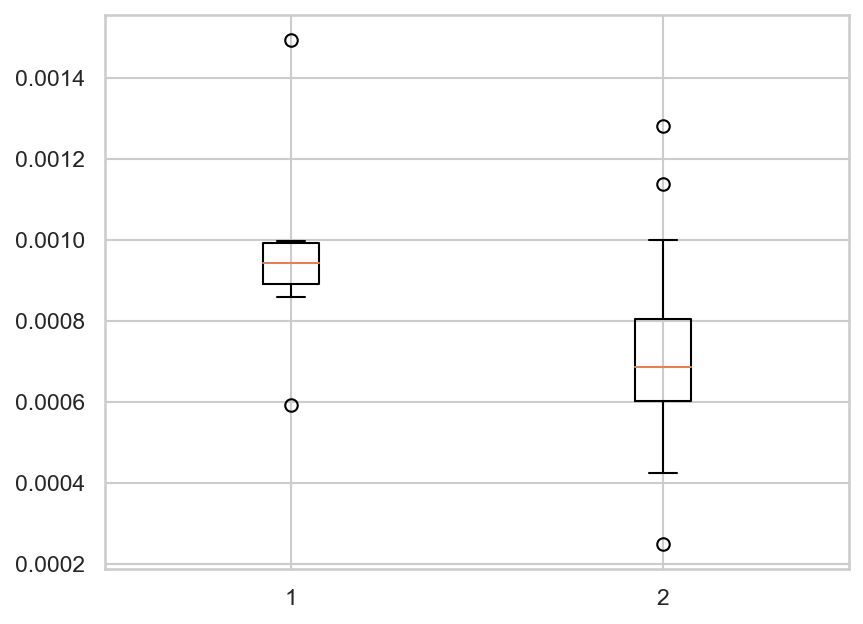

In [10]:
ko = "K01714"
lvr_abunds = ko_abunds_v5.loc[ko, meta_v5.query('VR_group == "LVR"').index]
nvr_abunds = ko_abunds_v5.loc[ko, meta_v5.query('VR_group == "NVR"').index]
_ = plt.boxplot([lvr_abunds, nvr_abunds])

In [11]:
print(len(ko_stats_v5.query('p_value < .05')))

32


When we do these correlations we get no significant after FDR correction. There is strong significance in the raw p-values though with 278 unadjusted p-values < .05. To take advantage of this result we will run a module enrichment test to look for enrichment of KEGG modules.

In [12]:
v5_sig_kos = set(ko_stats_v5.query('p_value < .05').index)
v5_enrichment = measure_enrichment(v5_sig_kos, modules, all_module_kos)
# v5_enrichment.to_csv('../../../data/stool_metag/ko_correlation_enrichment_V5.tsv', sep='\t')
v5_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00020,5,1,31,4,2200,17.741935,0.069598,1.0
M00309,8,1,31,7,2197,10.124424,0.109079,1.0
M00526,9,1,31,8,2196,8.854839,0.121875,1.0
M00525,9,1,31,8,2196,8.854839,0.121875,1.0
M00527,10,1,31,9,2195,7.867384,0.134493,1.0


### 4 months

In [13]:
ko_abunds_v6 = ko_abunds[meta_v6.index]
ko_abunds_v6 = ko_abunds_v6.loc[(ko_abunds_v6 > 0).sum(axis=1) > ko_abunds_v6.shape[1]*.2]
ko_abunds_v6 = ko_abunds_v6.loc[ko_abunds_v6.var(axis=1) > 1e-10] # variance filter
print(ko_abunds_v6.shape)

(4386, 45)


In [14]:
ko_stats_v6_rows = list()
for ko, row in ko_abunds_v6.iterrows():
    lvr_abunds = row[meta_v6.query('VR_group == "LVR"').index]
    nvr_abunds = row[meta_v6.query('VR_group == "NVR"').index]
    # check for not all zeros
    lvr_gt_20 = (lvr_abunds != 0).sum()/len(lvr_abunds) > .2
    nvr_gt_20 = (nvr_abunds != 0).sum()/len(nvr_abunds) > .2
    # lvr_gt_20 = lvr_abunds.sum()/len(lvr_abunds) > 5
    # nvr_gt_20 = nvr_abunds.sum()/len(nvr_abunds) > 5
    # print(lvr_gt_20, nvr_gt_20)
    if lvr_gt_20 or nvr_gt_20:
        stat, p_value = mannwhitneyu(lvr_abunds, nvr_abunds)
        ko_stats_v6_rows.append([ko, lvr_abunds.mean(), nvr_abunds.mean(), stat, p_value])
ko_stats_v6 = pd.DataFrame(ko_stats_v6_rows, columns=['ko', 'LVR_mean', 'NVR_mean', 'statistic', 'p_value']).sort_values('p_value')
ko_stats_v6 = ko_stats_v6.set_index('ko')
ko_stats_v6['p_adj'] = p_adjust(ko_stats_v6['p_value'])
ko_stats_v6.head()

,LVR_mean,NVR_mean,statistic,p_value,p_adj
ko,,,,,
K17243,0.000021,0.000001,303.0,0.000569,0.779967
K00094,0.000028,0.000096,82.5,0.003151,0.779967
K02436,0.000020,0.000058,87.5,0.004752,0.779967
K07334,0.000009,0.000032,89.0,0.005272,0.779967
K07075,0.000074,0.000031,304.0,0.006737,0.779967


In [15]:
print(len(ko_stats_v6.query('p_value < .05')))

201


Many fewer significant results than at 2 months but we will still look for enrichment.

In [16]:
v6_sig_kos = set(ko_stats_v6.query('p_value < .05').index)
v6_enrichment = measure_enrichment(v6_sig_kos, modules, all_module_kos)
v6_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00911,8,2,199,6,2188,3.664992,0.140302,1.0
M00525,9,2,199,7,2187,3.139986,0.170823,1.0
M00527,10,2,199,8,2186,2.746231,0.202296,1.0
M00016,13,2,199,11,2183,1.994518,0.298968,1.0
M00575,5,1,200,4,2190,2.737500,0.355105,1.0


We find nothing though.

### 6 months

In [17]:
ko_abunds_v7 = ko_abunds[meta_v7.index]
ko_abunds_v7 = ko_abunds_v7.loc[(ko_abunds_v7 > 0).sum(axis=1) > ko_abunds_v7.shape[1]*.2]
ko_abunds_v7 = ko_abunds_v7.loc[ko_abunds_v7.var(axis=1) > 1e-10] # variance filter
print(ko_abunds_v7.shape)

(4330, 50)


In [18]:
ko_stats_v7_rows = list()
for ko, row in ko_abunds_v7.iterrows():
    lvr_abunds = row[meta_v7.query('VR_group == "LVR"').index]
    nvr_abunds = row[meta_v7.query('VR_group == "NVR"').index]
    # check for not all zeros
    lvr_gt_20 = (lvr_abunds != 0).sum()/len(lvr_abunds) > .2
    nvr_gt_20 = (nvr_abunds != 0).sum()/len(nvr_abunds) > .2
    # lvr_gt_20 = lvr_abunds.sum()/len(lvr_abunds) > 5
    # nvr_gt_20 = nvr_abunds.sum()/len(nvr_abunds) > 5
    # print(lvr_gt_20, nvr_gt_20)
    if lvr_gt_20 or nvr_gt_20:
        stat, p_value = mannwhitneyu(lvr_abunds, nvr_abunds)
        ko_stats_v7_rows.append([ko, lvr_abunds.mean(), nvr_abunds.mean(), stat, p_value])
ko_stats_v7 = pd.DataFrame(ko_stats_v7_rows, columns=['ko', 'LVR_mean', 'NVR_mean', 'statistic', 'p_value']).sort_values('p_value')
ko_stats_v7['p_adj'] = p_adjust(ko_stats_v7['p_value'])
ko_stats_v7 = ko_stats_v7.set_index('ko')
ko_stats_v7.head()

,LVR_mean,NVR_mean,statistic,p_value,p_adj
ko,,,,,
K07775,0.000009,0.000011,339.0,0.000582,0.998405
K01179,0.000237,0.000070,358.0,0.000728,0.998405
K06937,0.000007,0.000003,331.0,0.001855,0.998405
K19309,0.000106,0.000035,346.0,0.002150,0.998405
K03205,0.001154,0.000766,331.0,0.006594,0.998405


In [19]:
print(len(ko_stats_v7.query('p_value < .05')))

100


Many fewer significant results than at 2 months but we will still look for enrichment.

In [20]:
v7_sig_kos = set(ko_stats_v7.query('p_value < .05').index)
v7_enrichment = measure_enrichment(v7_sig_kos, modules, all_module_kos)
v7_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00580,5,1,99,4,2190,5.530303,0.199927,1.0
M00345,7,1,99,6,2188,3.683502,0.268320,1.0
M00631,8,1,99,7,2187,3.155844,0.300313,1.0
M00868,8,1,99,7,2187,3.155844,0.300313,1.0
M00911,8,1,99,7,2187,3.155844,0.300313,1.0


We find nothing though.

### 1 year

In [21]:
ko_abunds_v9 = ko_abunds[meta_v9.index]
ko_abunds_v9 = ko_abunds_v9.loc[(ko_abunds_v9 > 0).sum(axis=1) > ko_abunds_v9.shape[1]*.2]
ko_abunds_v9 = ko_abunds_v9.loc[ko_abunds_v9.var(axis=1) > 1e-10] # variance filter
print(ko_abunds_v9.shape)

(4259, 42)


In [22]:
ko_stats_v9_rows = list()
for ko, row in ko_abunds_v9.iterrows():
    lvr_abunds = row[meta_v9.query('VR_group == "LVR"').index]
    nvr_abunds = row[meta_v9.query('VR_group == "NVR"').index]
    # check for not all zeros
    lvr_gt_20 = (lvr_abunds != 0).sum()/len(lvr_abunds) > .2
    nvr_gt_20 = (nvr_abunds != 0).sum()/len(nvr_abunds) > .2
    # lvr_gt_20 = lvr_abunds.sum()/len(lvr_abunds) > 5
    # nvr_gt_20 = nvr_abunds.sum()/len(nvr_abunds) > 5
    # print(lvr_gt_20, nvr_gt_20)
    if lvr_gt_20 or nvr_gt_20:
        stat, p_value = mannwhitneyu(lvr_abunds, nvr_abunds)
        ko_stats_v9_rows.append([ko, lvr_abunds.mean(), nvr_abunds.mean(), stat, p_value])
ko_stats_v9 = pd.DataFrame(ko_stats_v9_rows, columns=['ko', 'LVR_mean', 'NVR_mean', 'statistic', 'p_value']).sort_values('p_value')
ko_stats_v9['p_adj'] = p_adjust(ko_stats_v9['p_value'])
ko_stats_v9 = ko_stats_v9.set_index('ko')
ko_stats_v9.head()

,LVR_mean,NVR_mean,statistic,p_value,p_adj
ko,,,,,
K02346,0.000734,0.000534,217.0,0.000635,0.916182
K02238,0.000946,0.000670,209.0,0.002214,0.916182
K03301,0.000047,0.000013,194.5,0.004025,0.916182
K08156,0.000499,0.000304,204.0,0.004359,0.916182
K05708,0.000000,0.000014,42.0,0.004596,0.916182


In [23]:
print(len(ko_stats_v9.query('p_value < .05')))

162


At one year there is a large number of significant KOs. An alarmingly large number.

In [24]:
v9_sig_kos = set(ko_stats_v9.query('p_value < .05').index)
v9_enrichment = measure_enrichment(v9_sig_kos, modules, all_module_kos)
v9_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00023,15,5,157,10,2170,6.910828,0.002532,0.76962
M00532,15,3,159,12,2168,3.408805,0.079945,1.00000
M00545,11,2,160,9,2171,3.015278,0.173653,1.00000
M00899,5,1,161,4,2176,3.378882,0.301430,1.00000
M00531,6,1,161,5,2175,2.701863,0.349854,1.00000


But after testing for enrichment none is found.